In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


In [2]:
# df = pd.read_csv('/home/alumnadotarde/Descargas/Bitcoin.csv')
df = pd.read_csv('./bitcoin.csv', delimiter=',')
df.head()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
0,12.12.2024,"100.347,3","101.126,3","102.495,3","99.334,5","189,02K","-0,77%"
1,11.12.2024,"101.126,2","96.603,2","101.877,1","95.689,5","250,02K","4,69%"
2,10.12.2024,"96.600,3","97.311,5","98.237,8","94.304,5","271,45K","-0,78%"
3,09.12.2024,"97.359,4","101.129,7","101.198,6","94.395,8","321,01K","-3,72%"
4,08.12.2024,"101.115,8","99.837,0","101.339,9","98.713,9","128,93K","1,28%"


In [3]:
df.describe()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
count,4719,4719,4719,4719,4719,4719,4719
unique,4719,4243,4236,4225,4243,4261,1456
top,12.01.2012,"5,1","5,1","5,1","5,1","1,05M","0,00%"
freq,1,26,26,21,21,6,130


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4719 entries, 0 to 4718
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Fecha     4719 non-null   object
 1   Último    4719 non-null   object
 2   Apertura  4719 non-null   object
 3   Máximo    4719 non-null   object
 4   Mínimo    4719 non-null   object
 5   Vol.      4719 non-null   object
 6   % var.    4719 non-null   object
dtypes: object(7)
memory usage: 258.2+ KB


Error cuadrático medio (MSE): 222546.86651660682
Raíz del error cuadrático medio (RMSE): 471.7487323953365


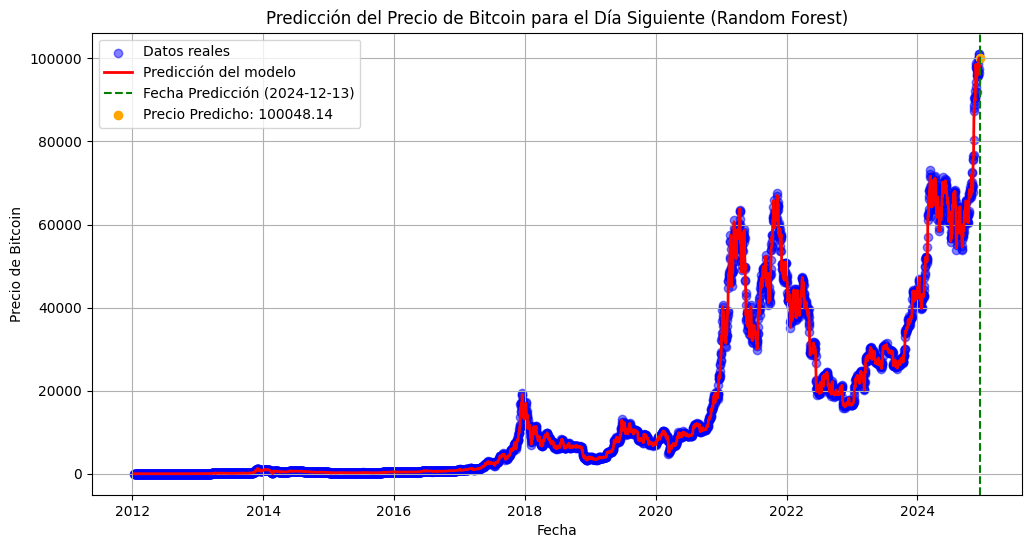

El precio predicho del Bitcoin para el día 2024-12-13 es: 100048.14


In [5]:
# Convertir fecha a formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d.%m.%Y', errors='coerce')
df = df.sort_values(by='Fecha')

# Verificar y limpiar las columnas numéricas
for col in ['Último', 'Apertura', 'Máximo', 'Mínimo']:
    if df[col].dtype == 'object':  # Limpiar solo si el tipo es texto
        df[col] = df[col].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)

# Limpiar la columna de Volumen
if df['Vol.'].dtype == 'object':  # Limpiar solo si el tipo es texto
    df['Vol.'] = (
        df['Vol.']
        .str.replace('K', '*1e3', regex=False)  # Miles
        .str.replace('M', '*1e6', regex=False)  # Millones
        .str.replace('B', '*1e9', regex=False)  # Miles de millones
        .str.replace('.', '', regex=False)  # Eliminar puntos
        .str.replace(',', '.', regex=False)  # Reemplazar comas por puntos
        .map(eval)  # Evaluar las expresiones matemáticas
    )

# Convertir fecha a número ordinal
df['Fecha_ordinal'] = df['Fecha'].map(pd.Timestamp.toordinal)

# Crear las variables independientes (características)
X = df[['Fecha_ordinal', 'Apertura', 'Máximo', 'Mínimo', 'Vol.']]

# La variable dependiente será el 'Último' (el precio final del día)
y = df['Último']

# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

# Crear el modelo Random Forest con hiperparámetros ajustados
model_rf = RandomForestRegressor(
    n_estimators=200,           # Número moderado de árboles para un dataset pequeño
    max_depth=15,               # Profundidad máxima para evitar sobreajuste
    min_samples_split=5,        # Mínimas muestras para dividir un nodo
    min_samples_leaf=2,         # Mínimas muestras en una hoja
    max_features="sqrt",       # Selección de número de variables en cada división
    random_state=44            # Reproducibilidad
)

# Entrenar el modelo
model_rf.fit(X_train, y_train)

# Predecir los precios para el conjunto de prueba
y_pred_rf = model_rf.predict(X_test)

# Evaluar el modelo
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5
print(f"Error cuadrático medio (MSE): {mse_rf}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse_rf}")

# Predicción para el siguiente día (última fecha del dataset + 1 día)
proxima_fecha = df['Fecha'].max() + pd.Timedelta(days=1)
proxima_fecha_ordinal = proxima_fecha.toordinal()
entrada_prediccion = pd.DataFrame({
    'Fecha_ordinal': [proxima_fecha_ordinal],
    'Apertura': [df['Apertura'].iloc[-1]],
    'Máximo': [df['Máximo'].iloc[-1]],
    'Mínimo': [df['Mínimo'].iloc[-1]],
    'Vol.': [df['Vol.'].iloc[-1]]
})
precio_predicho_rf = model_rf.predict(entrada_prediccion)[0]

# Graficar resultados
plt.figure(figsize=(12, 6))

# Gráfica de los datos reales
plt.scatter(df['Fecha'], df['Último'], color='blue', label='Datos reales', alpha=0.5)

# Gráfica de las predicciones del modelo sobre los datos históricos
predicciones_historicas_rf = model_rf.predict(X)
plt.plot(df['Fecha'], predicciones_historicas_rf, color='red', label='Predicción del modelo', linewidth=2)

# Punto para la predicción del día siguiente
plt.axvline(x=proxima_fecha, color='green', linestyle='--', label=f'Fecha Predicción ({proxima_fecha.date()})')
plt.scatter(proxima_fecha, precio_predicho_rf, color='orange', label=f'Precio Predicho: {precio_predicho_rf:.2f}')

# Etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Precio de Bitcoin')
plt.title('Predicción del Precio de Bitcoin para el Día Siguiente (Random Forest)')
plt.legend()
plt.grid()
plt.show()

# Mostrar el precio predicho
print(f"El precio predicho del Bitcoin para el día {proxima_fecha.date()} es: {precio_predicho_rf:.2f}")

#222546.86651660682 44 44

In [6]:
print("Última fecha del dataset:", df['Fecha'].max())
print("Fecha de la predicción:", proxima_fecha)

Última fecha del dataset: 2024-12-12 00:00:00
Fecha de la predicción: 2024-12-13 00:00:00


In [7]:
df.tail()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.,Fecha_ordinal
4,2024-12-08,101115.8,99837.0,101339.9,98713.9,128930.0,"1,28%",739228
3,2024-12-09,97359.4,101129.7,101198.6,94395.8,321010.0,"-3,72%",739229
2,2024-12-10,96600.3,97311.5,98237.8,94304.5,271450.0,"-0,78%",739230
1,2024-12-11,101126.2,96603.2,101877.1,95689.5,250020.0,"4,69%",739231
0,2024-12-12,100347.3,101126.3,102495.3,99334.5,189020.0,"-0,77%",739232


## Arriba sin shift(RandomForestRegressor)

## Abajo con shift( y regresion)


Error Cuadrático Medio (MSE): 625637.5903674766


/home/feliciano/miniconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


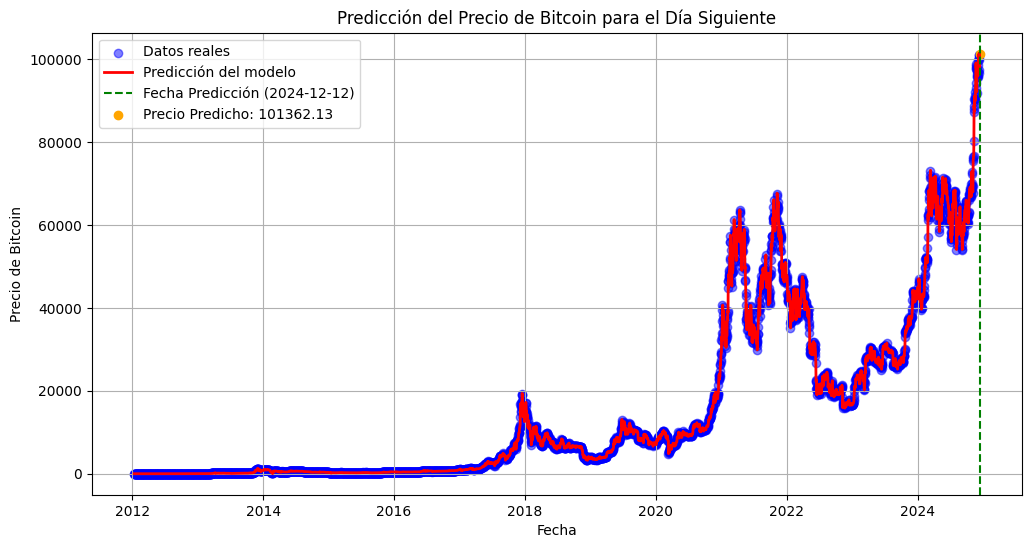

El precio predicho del Bitcoin para el día 2024-12-12 es: 101362.13


In [8]:
# Crear la columna del precio del día siguiente
df['Precio_Mañana'] = df['Último'].shift(-1)

# Eliminar filas con valores NaN
df = df.dropna()

# Crear las variables independientes (características) y dependiente (Precio_Mañana)
X = df[['Fecha_ordinal', 'Último']]
y = df['Precio_Mañana']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Entrenar el modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Predecir los precios para el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el Error Cuadrático Medio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Error Cuadrático Medio (MSE): {mse}')

# Predicción para el día siguiente (última fecha del dataset + 1 día)
proxima_fecha = df['Fecha'].max() + pd.Timedelta(days=1)
proxima_fecha_ordinal = proxima_fecha.toordinal()
entrada_prediccion = [[proxima_fecha_ordinal, df['Último'].iloc[-1]]]
precio_predicho = model.predict(entrada_prediccion)[0]



# Graficar resultados
plt.figure(figsize=(12, 6))

# Gráfica de los datos reales
plt.scatter(df['Fecha'], df['Precio_Mañana'], color='blue', label='Datos reales', alpha=0.5)

# Gráfica de las predicciones del modelo sobre los datos históricos
predicciones_historicas = model.predict(X)
plt.plot(df['Fecha'], predicciones_historicas, color='red', label='Predicción del modelo', linewidth=2)

# Punto para la predicción del día siguiente
plt.axvline(x=proxima_fecha, color='green', linestyle='--', label=f'Fecha Predicción ({proxima_fecha.date()})')
plt.scatter(proxima_fecha, precio_predicho, color='orange', label=f'Precio Predicho: {precio_predicho:.2f}')

# Etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Precio de Bitcoin')
plt.title('Predicción del Precio de Bitcoin para el Día Siguiente')
plt.legend()
plt.grid()
plt.show()

# Mostrar el precio predicho
print(f"El precio predicho del Bitcoin para el día {proxima_fecha.date()} es: {precio_predicho:.2f}")

In [9]:
print("Última fecha del dataset:", df['Fecha'].max())
print("Fecha de la predicción:", proxima_fecha)


Última fecha del dataset: 2024-12-11 00:00:00
Fecha de la predicción: 2024-12-12 00:00:00


In [10]:
df.tail()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.,Fecha_ordinal,Precio_Mañana
5,2024-12-07,99837.0,99757.2,100441.8,98969.0,118440.0,"0,08%",739227,101115.8
4,2024-12-08,101115.8,99837.0,101339.9,98713.9,128930.0,"1,28%",739228,97359.4
3,2024-12-09,97359.4,101129.7,101198.6,94395.8,321010.0,"-3,72%",739229,96600.3
2,2024-12-10,96600.3,97311.5,98237.8,94304.5,271450.0,"-0,78%",739230,101126.2
1,2024-12-11,101126.2,96603.2,101877.1,95689.5,250020.0,"4,69%",739231,100347.3


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4718 entries, 4718 to 1
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Fecha          4718 non-null   datetime64[ns]
 1   Último         4718 non-null   float64       
 2   Apertura       4718 non-null   float64       
 3   Máximo         4718 non-null   float64       
 4   Mínimo         4718 non-null   float64       
 5   Vol.           4718 non-null   float64       
 6   % var.         4718 non-null   object        
 7   Fecha_ordinal  4718 non-null   int64         
 8   Precio_Mañana  4718 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 368.6+ KB


In [12]:
# # Crear las variables independientes (Fecha como número ordinal) y dependiente (Precio_Mañana)
# X = df[['Fecha_ordinal']].values
# y = df['Precio_Mañana'].values

# # Dividir los datos en entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Entrenar el modelo de regresión lineal
# model = LinearRegression()
# model.fit(X_train, y_train)

# # Predecir los precios para el conjunto de prueba
# y_pred = model.predict(X_test)

# # Graficar los resultados
# plt.figure(figsize=(12, 6))
# plt.scatter(df['Fecha'], df['Precio_Mañana'], color='blue', label='Datos reales', alpha=0.5)
# plt.plot(df['Fecha'], model.predict(df[['Fecha_ordinal']]), color='red', label='Predicción del modelo', linewidth=2)
# plt.xlabel('Fecha')
# plt.ylabel('Precio de Bitcoin')
# plt.title('Predicción del Precio de Bitcoin para el Día Siguiente')
# plt.legend()
# plt.grid()
# plt.show()